In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import os 
os.chdir("..")
plt.style.use('plot_style.txt')
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])

plt.rc('axes',prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid') 
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
from matplotlib import cm
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns

In [2]:
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Turn off tqdm for a clean display 

In [3]:
s1=5.1667 / 1.0
s2=5.1667 / 1.5
a_scale = 100

In [4]:
marker_list = ['^','<','>','v','*','o','+','1','2']

In [5]:
fig_save_path = os.path.join(os.path.abspath(os.curdir), "Simulation", 'figures')

In [6]:
import VPSModeling.Network as net

In [7]:
import pickle
y_scale=100

In [8]:
A = 1
B = 115
C=20
this_amp_exc=2/B 
this_amp_inh=1/C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = [0.003,0.002,0.001,0]



frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]


pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()



exc_overlap_list =[]



this_sig_list =np.array([0.25,0.5,0.75,1,1.25,1.5])#,1.75,2])


alpha_response_list = []
this_alpha=0.003*a_scale


for v1_amp_scale in tqdm(this_sig_list):
    v1_sigma_Ex_scale = 1 * v1_amp_scale # *unit_2_scale
    v1_sigma_inh_scale =1 # *unit_2_scale
    #v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale

    overlap = []

    for i in range(len(frequency_list)): 

        stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

        I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

        I.fill(trough)

        time_ed1 = time_st1 + stimulus_duration


        time_st2 = time_ed1 + stimulus_duration
        time_ed2 = time_st2 + stimulus_duration

        I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
        I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )


        this_X_vec = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)

        a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
        b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

        response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
        response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]


        overlap.append(net.get_2response_pdf_v(response1,response2))

    exc_overlap_list.append(overlap)







# Figure 5D, 5C  right panel

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


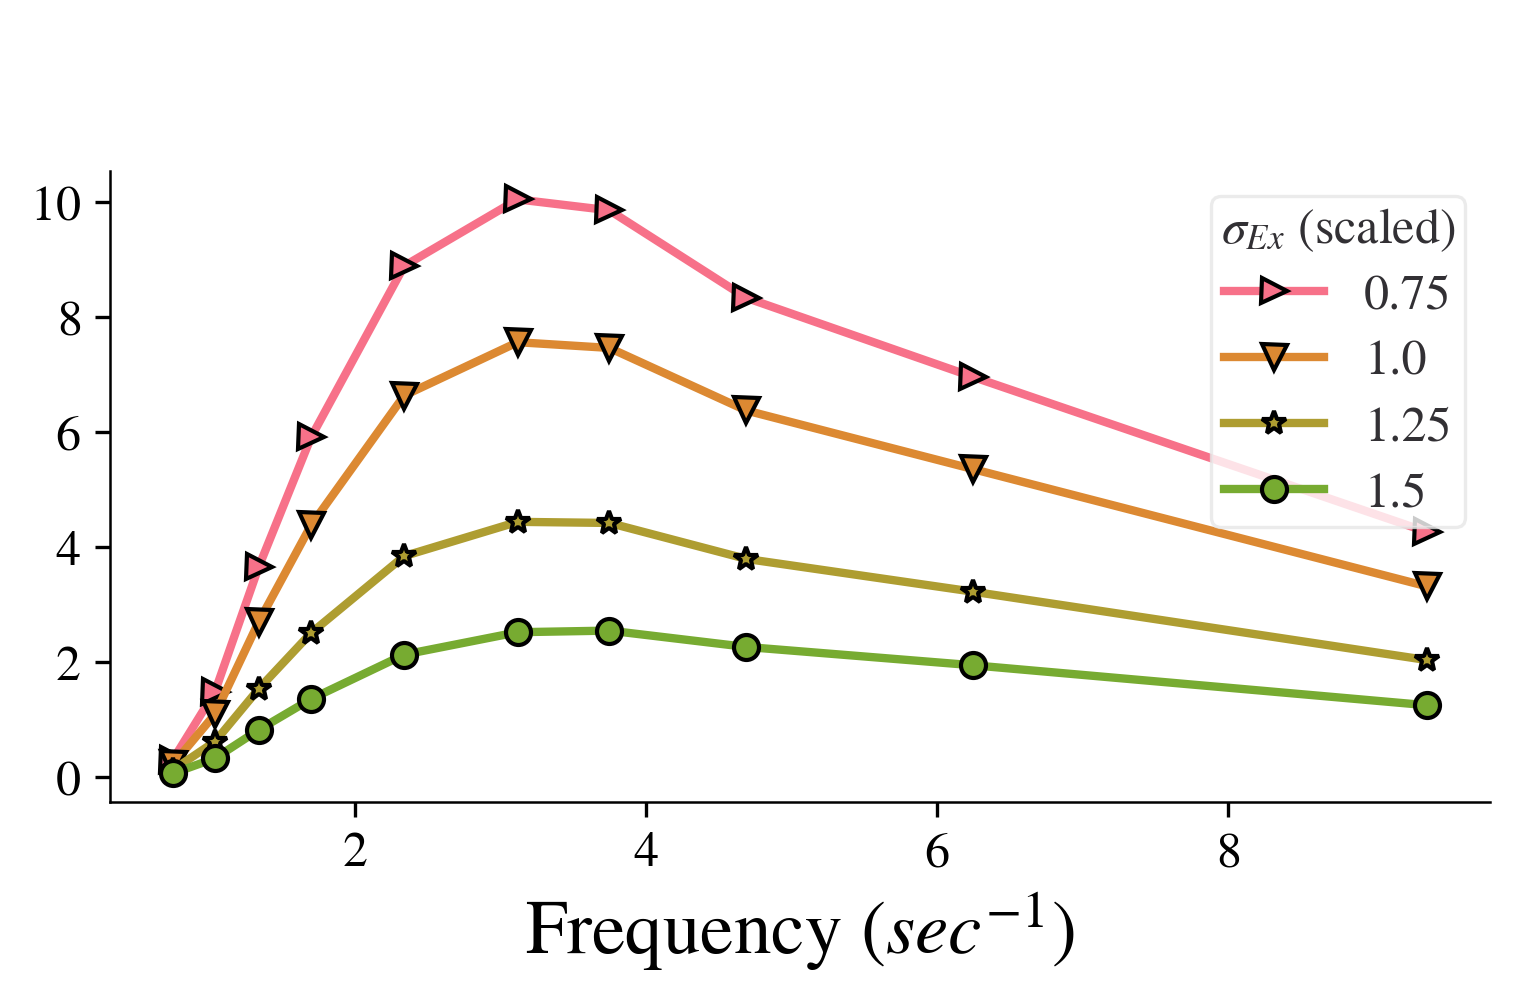

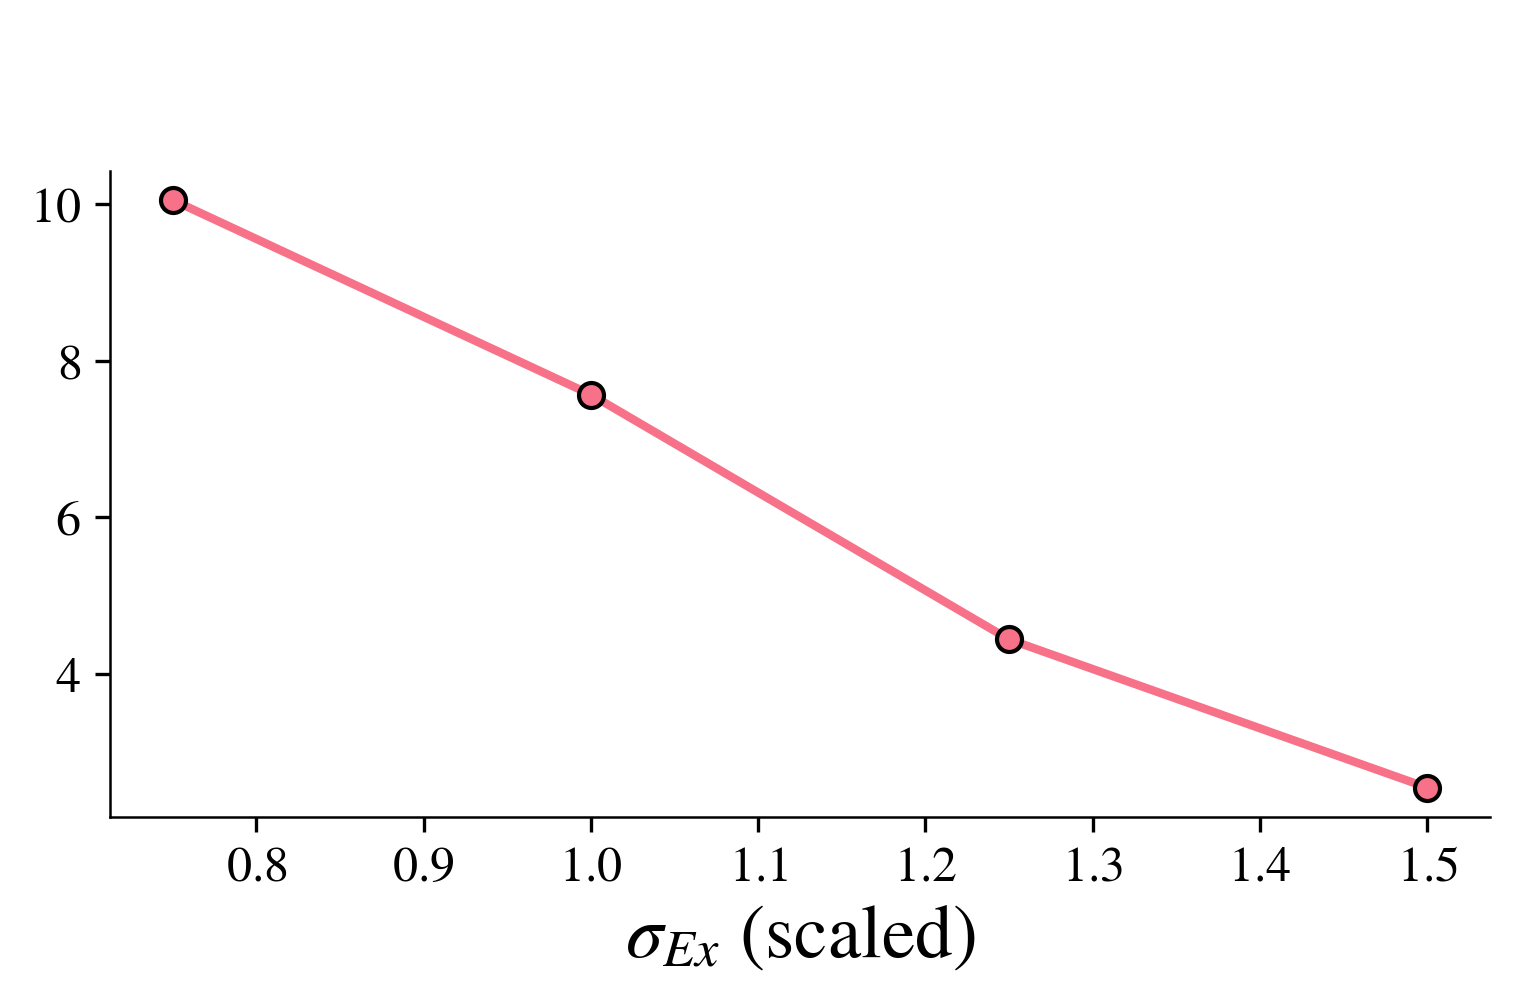

In [10]:


pal=sns.color_palette("husl", 10)

a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)
plt.figure(figsize=(s1, s2))
exc_overlap_list = np.array(exc_overlap_list)
for i in range(2, len(this_sig_list)):
    plt.plot(frequency_list,np.squeeze(exc_overlap_list[i]),marker=marker_list[i],label=str(this_sig_list[i]))

plt.xlabel(r"Frequency $(sec^{-1})$")

plt.legend(title=r'$\sigma_{Ex}$ (scaled)', loc='upper right',fontsize=12, title_fontsize=12) #,fontsize=7.5, title_fontsize=7.5 )# bbox_to_anchor=(1, 0.5))

plt.title('\n\t', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_exc_sig_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_exc_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    
    
plt.figure(figsize=(s1, s2))
max_overlap_list =[]
for i in range(2,len(exc_overlap_list)):
    max_overlap_list.append(np.max((exc_overlap_list[i])))
plt.plot(this_sig_list[2:], np.array(max_overlap_list),marker='o')
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')

plt.title('\n\t', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_exc_sig_hi_plot.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_exc_sig_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)




# Figure 5D, 5C left panel

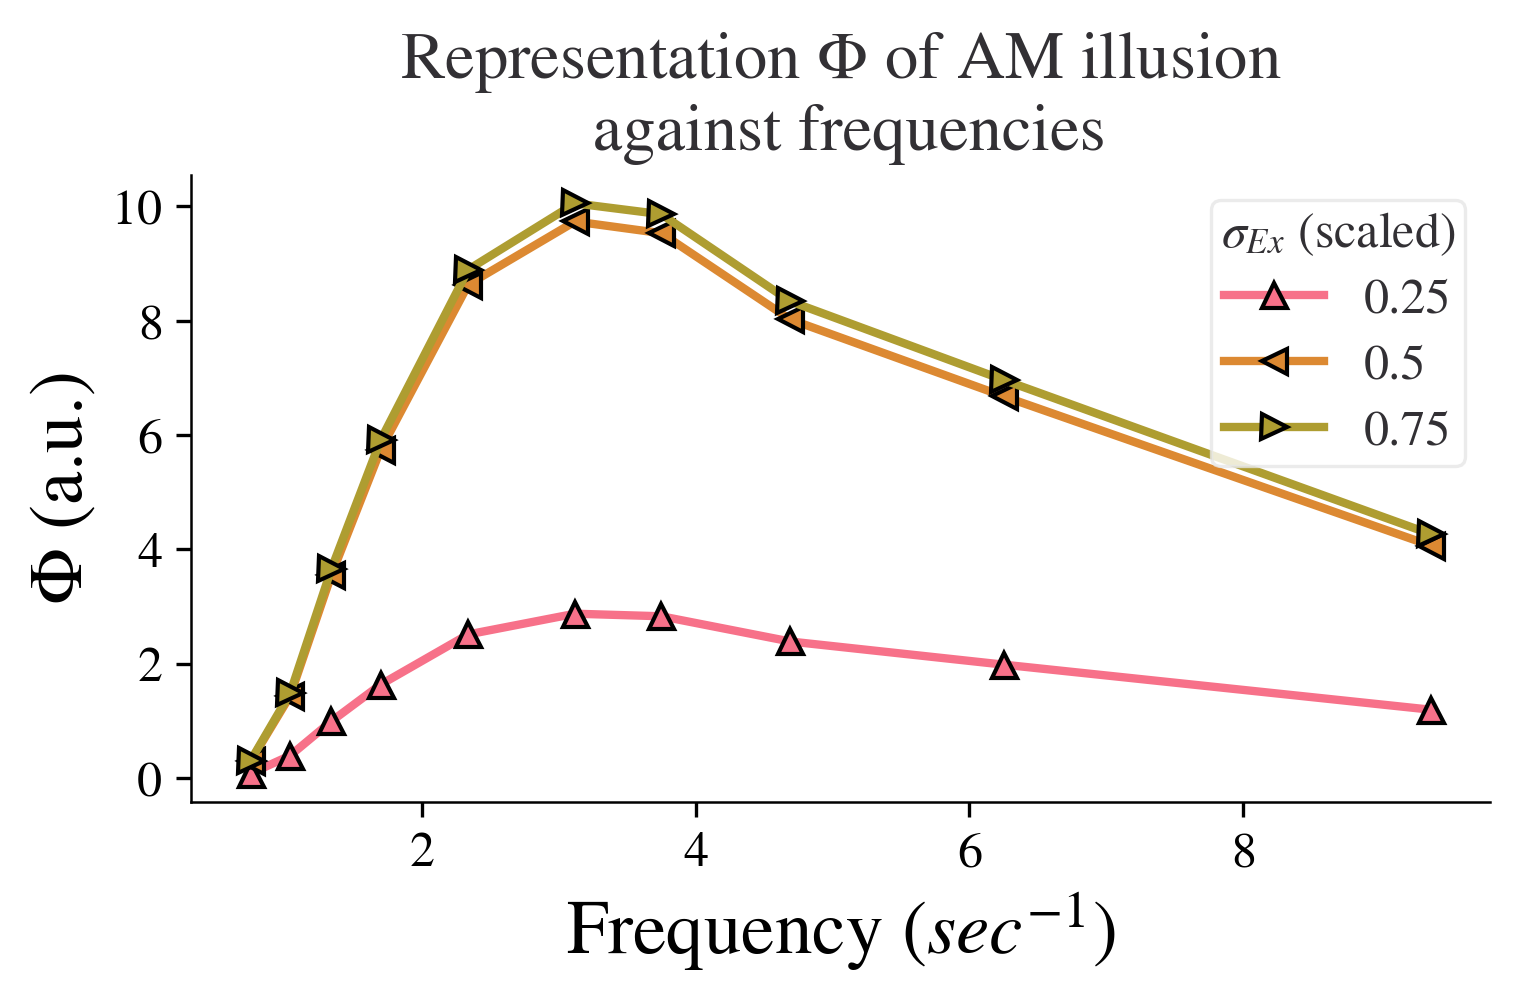

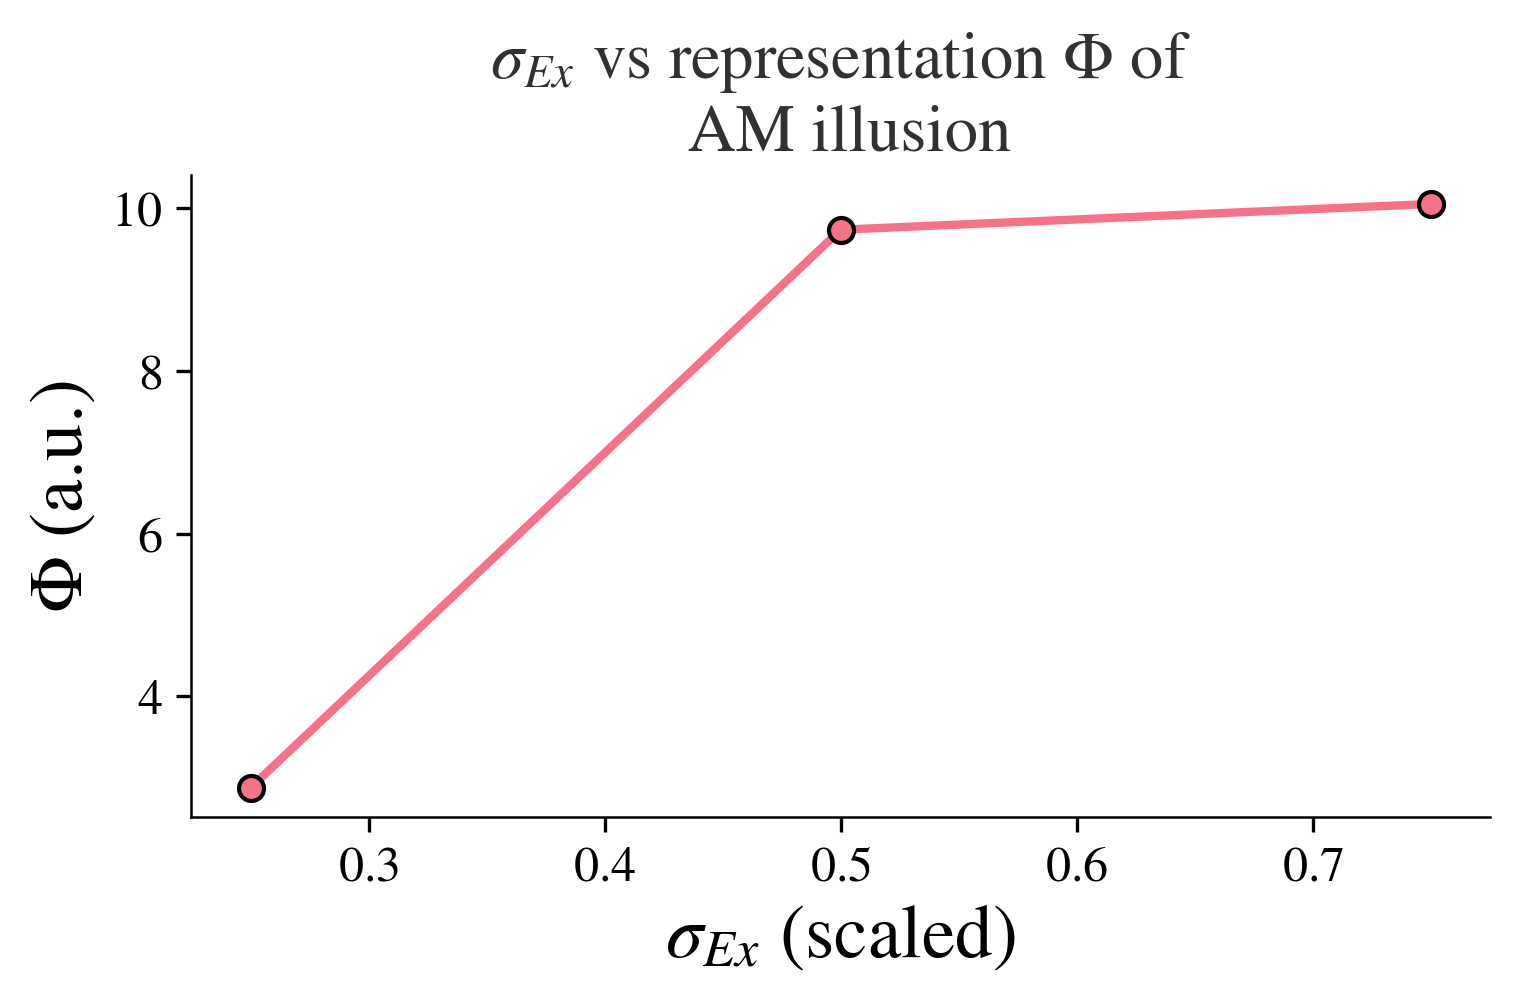

In [10]:
pal=sns.color_palette("husl", 10)

a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)
plt.figure(figsize=(s1, s2))
exc_overlap_list = np.array(exc_overlap_list)
for i in range(0, 3):
    plt.plot(frequency_list,np.squeeze(exc_overlap_list[i]),marker=marker_list[i],label=str(this_sig_list[i]))

plt.xlabel(r"Frequency $(sec^{-1})$")
plt.ylabel("$\Phi$ (a.u.)")
plt.legend(title=r'$\sigma_{Ex}$ (scaled)', loc='upper right',fontsize=12, title_fontsize=12) #,fontsize=7.5, title_fontsize=7.5 )# bbox_to_anchor=(1, 0.5))
plt.title('Representation $\Phi$ of AM illusion \n against frequencies', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_sm_exc_sig_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_sm_exc_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
        
plt.figure(figsize=(s1, s2))
max_overlap_list =[]
for i in range(0,3):
    max_overlap_list.append(np.max((exc_overlap_list[i])))
plt.plot(this_sig_list[:3], np.array(max_overlap_list),marker='o')
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')
plt.ylabel("$\Phi$ (a.u.)")
plt.title(r'$\sigma_{Ex}$ vs representation $\Phi$ of' + '\n AM illusion', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_sm_exc_sig_hi_plot.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_sm_exc_sig_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

1.5442334557136868e-15


Text(0, 0.5, 'Density')

<Figure size 1550.01x1033.34 with 0 Axes>

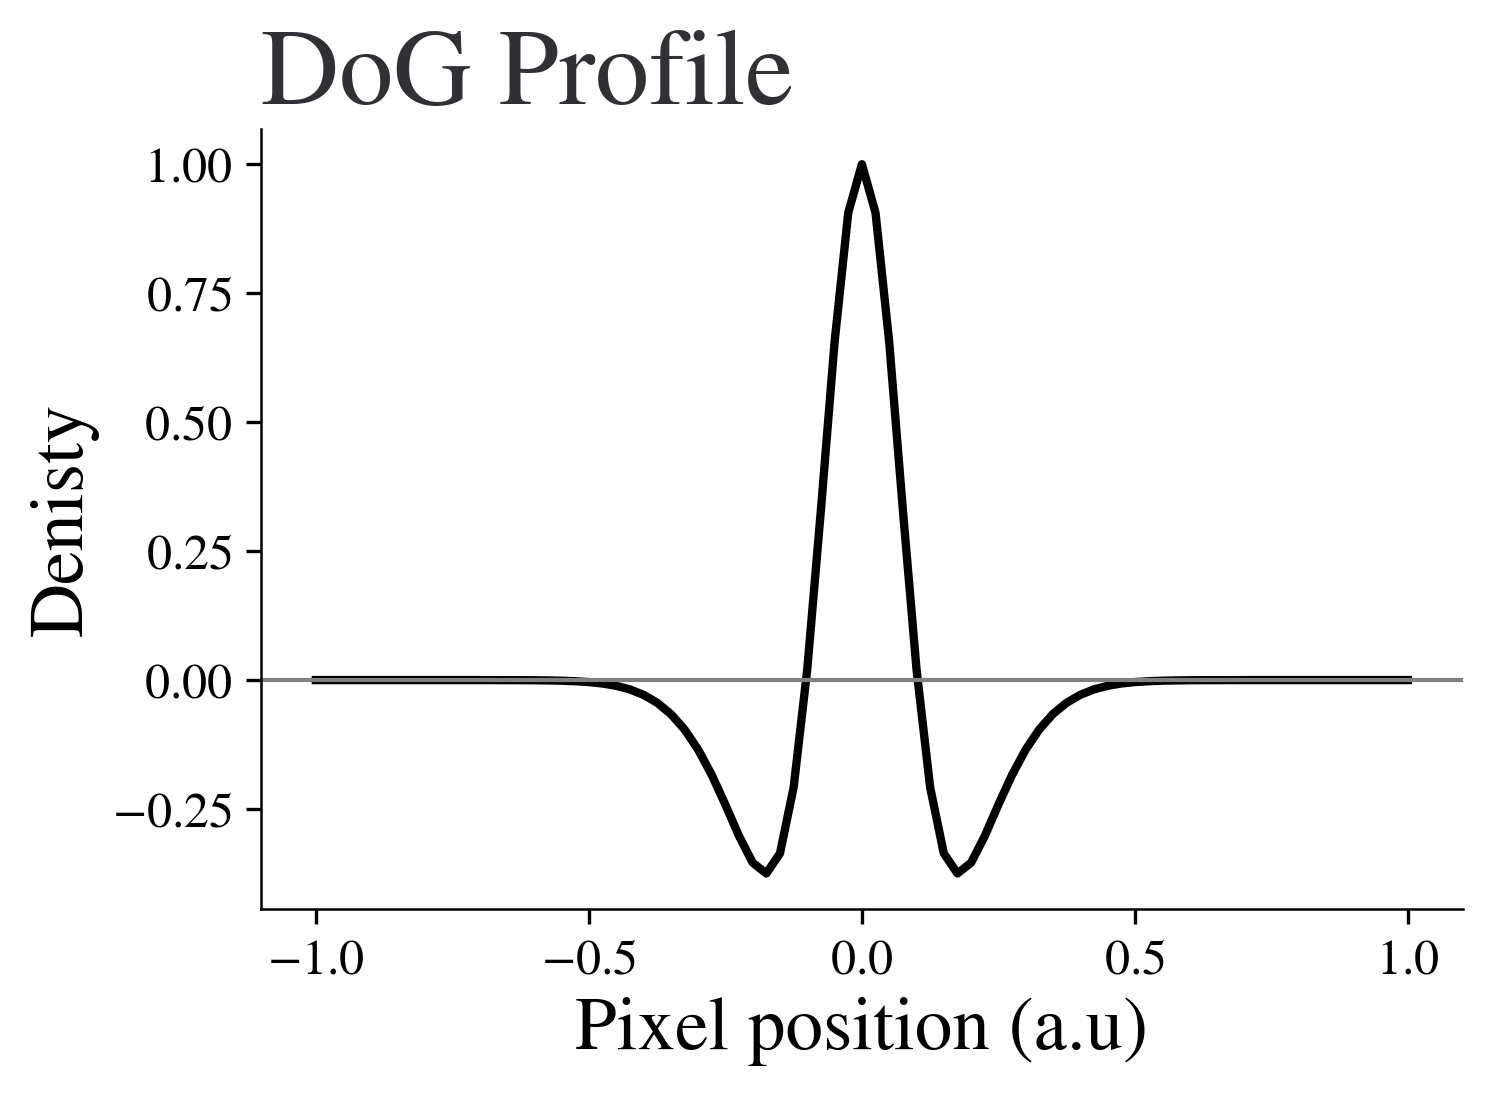

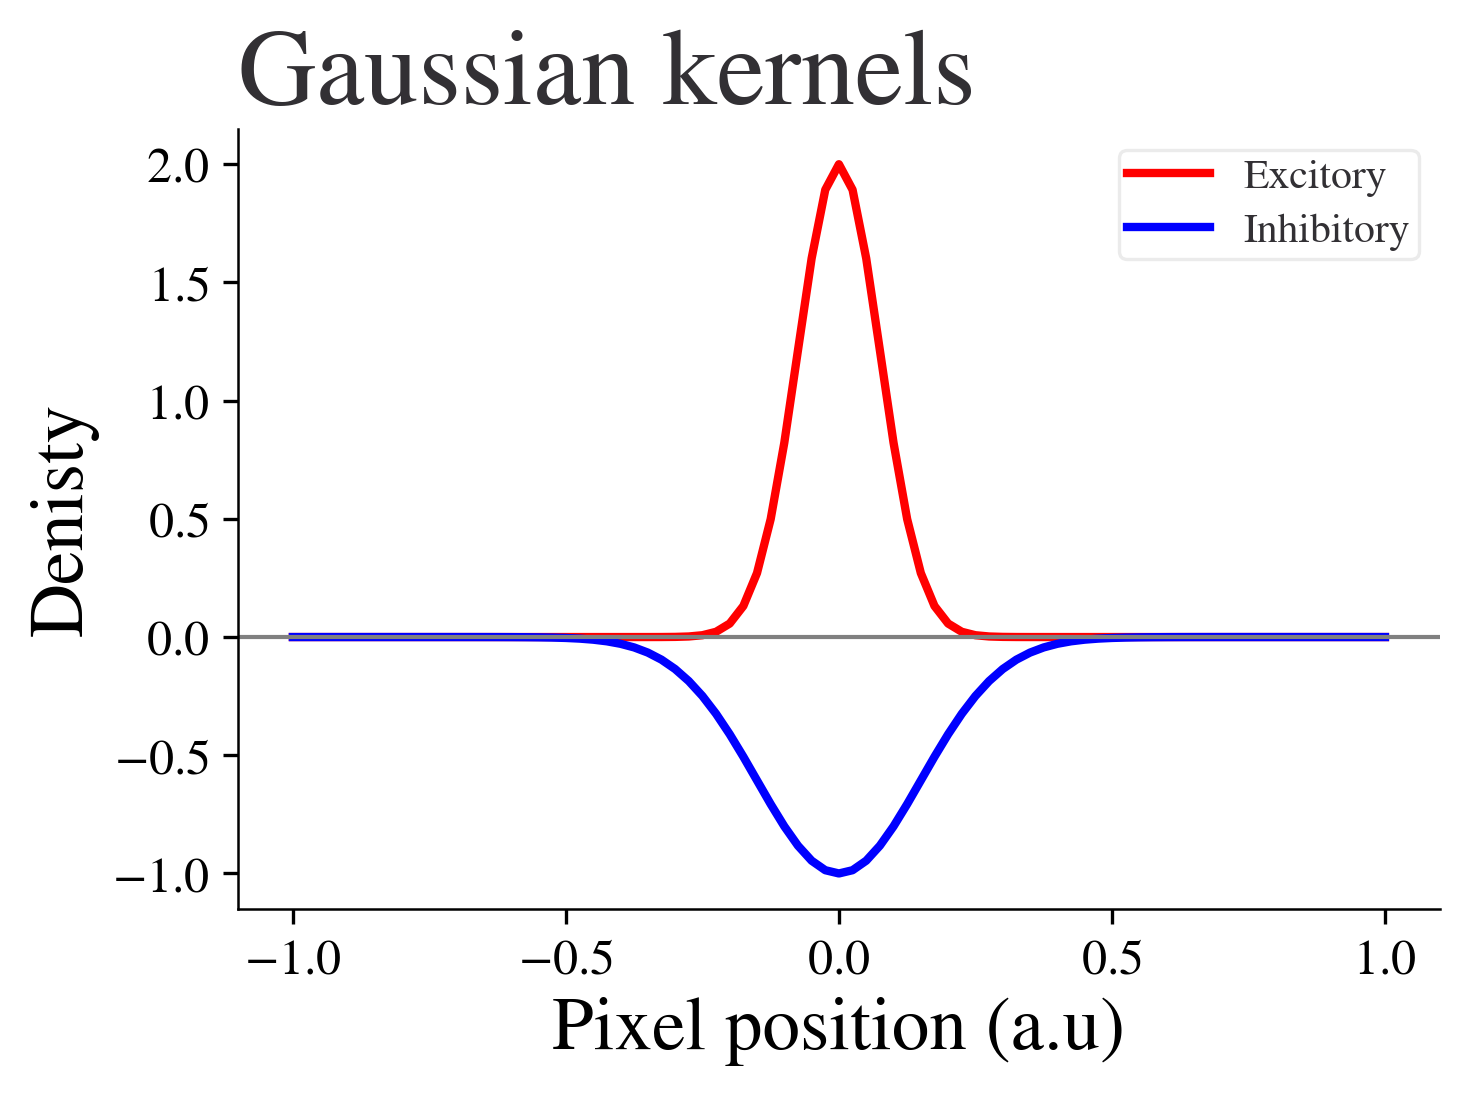

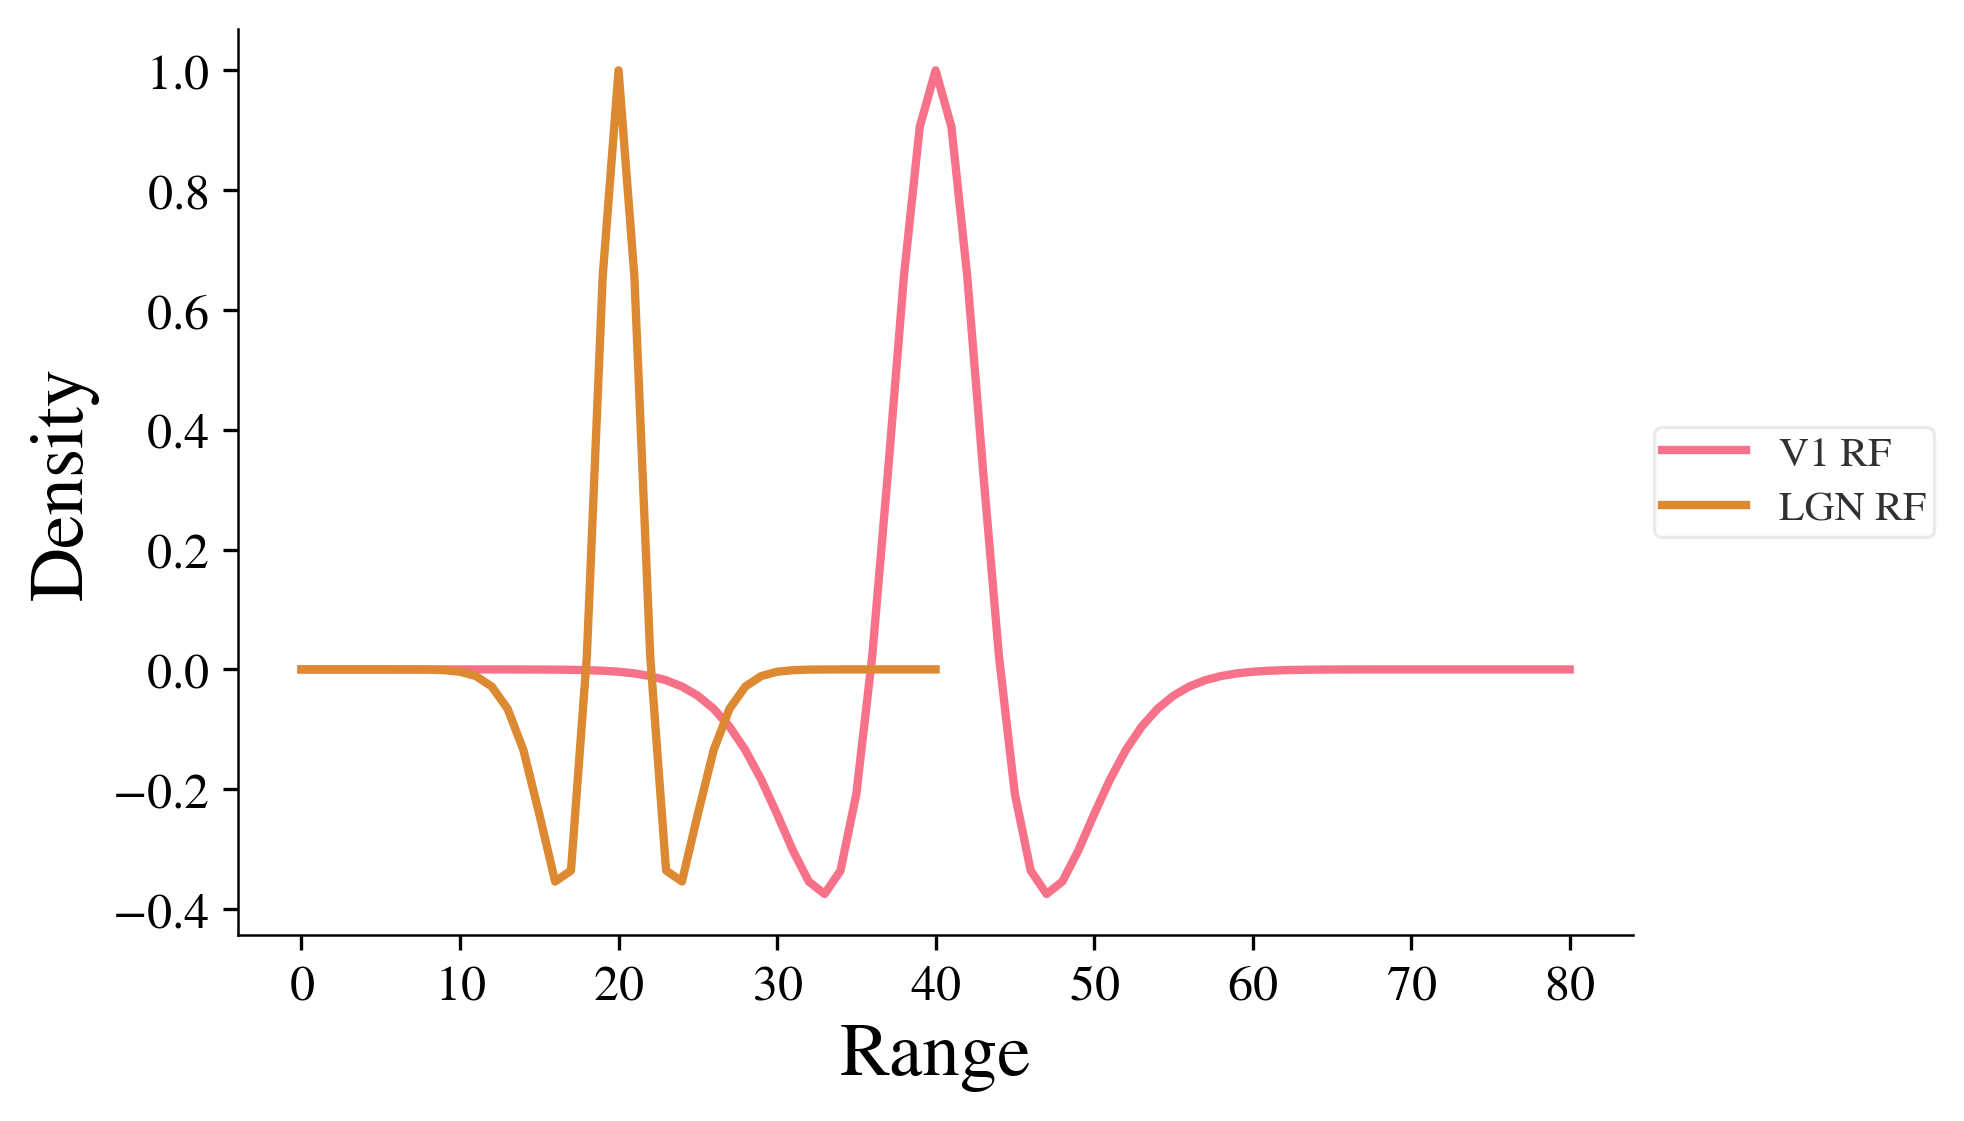

In [11]:
fig = plt.figure(figsize=(s1, s2))

v1_sigma_Ex_scale = 1
v1_sigma_inh_scale =1
v1_amp_scale = 1

this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
this_v1_sigma_inh = 0.2*v1_sigma_inh_scale



X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))
t=0
_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],
                                            filter_unit_2,this_v1_sigma_Ex ,
                                            this_v1_sigma_inh,  
                                            amp_inh=this_amp_inh,
                                            RF_scale=V1_RF_scale, amp_exc=this_amp_exc)


plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,c='black')
plt.xlabel("Pixel position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.title('DoG Profile')

plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex,c='r',label='Excitory')
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),-C*norm_G_Inh,c='b',label='Inhibitory')
plt.xlabel("Pixel position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.legend()
plt.title('Gaussian kernels')



plt.figure()

plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='V1 RF')
base_kernel = B*norm_G_Ex-C*norm_G_Inh

print(np.sum(base_kernel))



_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec[t,:],A,B,C,I[t,:],
                                            filter_unit,dt,dt*2,
                                            amp_inh=this_amp_inh,
                                            RF_scale=LGN_RF_scale,
                                            amp_exc=this_amp_exc
                                           )
plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='LGN RF')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Range")
plt.ylabel("Density")

In [12]:
A = 1
B = 115
C=20
this_amp_exc=2/B 
this_amp_inh=1/C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = [0.003,0.002,0.001,0]


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]


pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()


combine_overlap_list =[]


this_inh_sig_list = [0.75,1,1.25,1.5,1.75,2]#,
this_exc_sig_list = [0.75,1,1.25,1.5]

alpha_response_list = []
this_alpha=0.003 * a_scale

for v1_inh_scale in tqdm(this_inh_sig_list):
    for v1_exc_scale in tqdm(this_exc_sig_list):
        v1_sigma_Ex_scale = v1_exc_scale  # *unit_2_scale
        v1_sigma_inh_scale = v1_inh_scale # * v1_amp_scale# *unit_2_scale

        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale
        this_v1_amp_exc = this_amp_exc*1 


        overlap = []

        for i in range(len(frequency_list)): 

            stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

            I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

            I.fill(trough)

            time_ed1 = time_st1 + stimulus_duration


            time_st2 = time_ed1 + stimulus_duration
            time_ed2 = time_st2 + stimulus_duration

            I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
            I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


            X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                                filter_unit, filter_unit_2, dt,
                                                                                timestep, pixel_size, boundary_size,
                                                                                this_alpha=this_alpha,
                                                                                this_amp_inh=this_amp_inh,
                                                                                this_amp_exc=this_amp_exc,
                                                                                v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                                v1_amp_inh=this_v1_amp_inh, 
                                                                                LGN_RF_scale=LGN_RF_scale,
                                                                                V1_RF_scale=V1_RF_scale, 
                                                                                v1_amp_exc=this_amp_exc  )


            this_X_vec = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
            this_X_vec_V1 = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
            this_X_vec_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
            this_X_vec_V1_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)



            a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
            b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

            response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
            response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]

            overlap.append(net.get_2response_pdf_v(response1,response2))

        combine_overlap_list.append(overlap)









# Figure 7B

<Figure size 1550.01x1033.34 with 0 Axes>

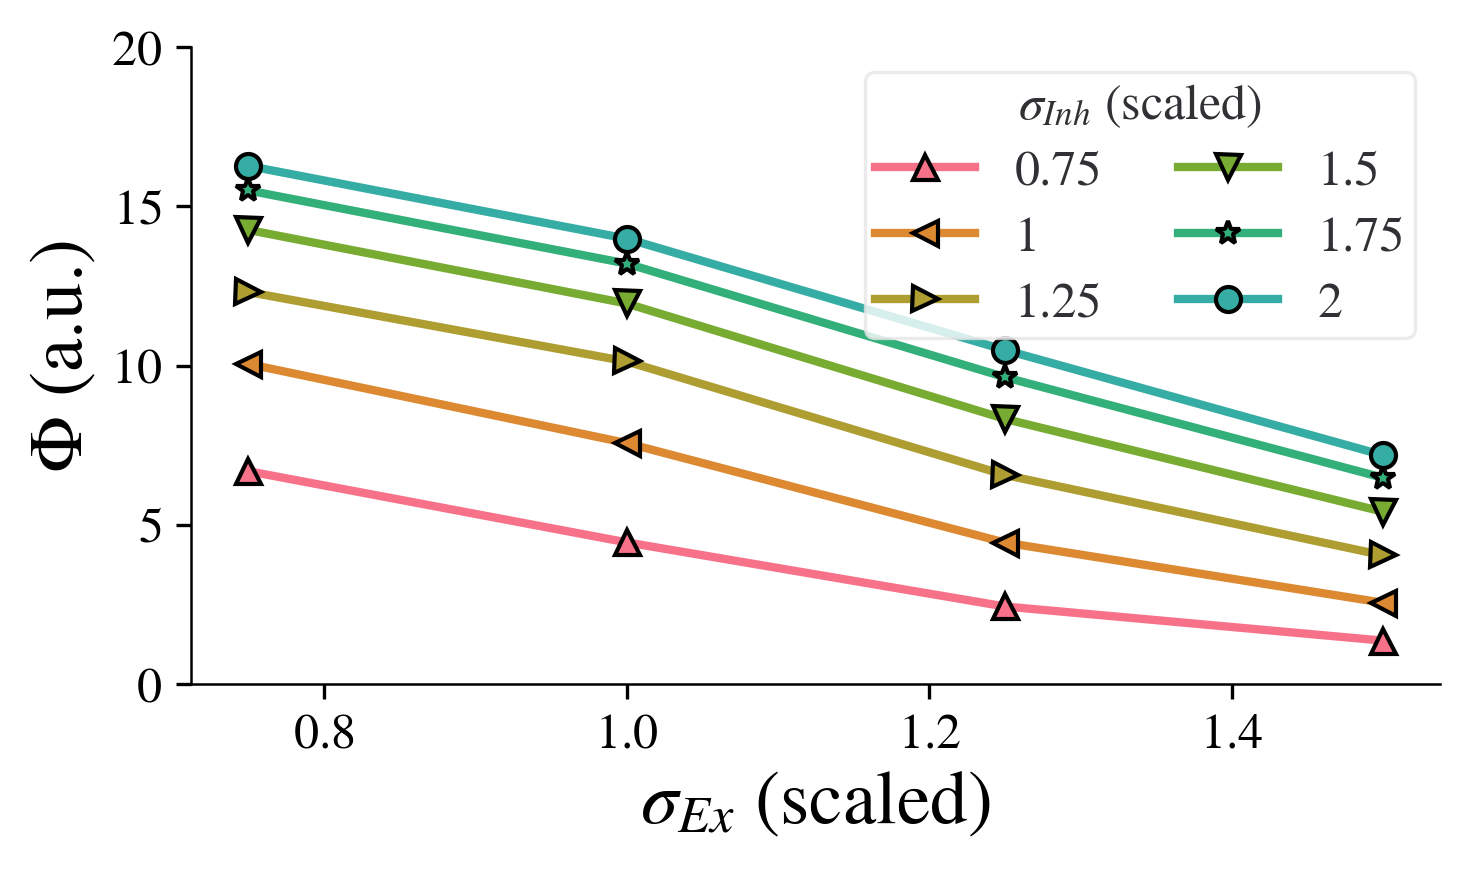

In [13]:
plt.figure(figsize=(s1, s2))

this_inh_sig_list = [0.75,1,1.25,1.5,1.75,2]#,
this_exc_sig_list = [0.75,1,1.25,1.5]

pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white',prop_cycle= colors)

len_j = len(this_exc_sig_list)

r_2d_wo_f = []
plt.figure(figsize=(5, 3))


for i in range(len(this_inh_sig_list)):   
    this_i_list = []
    for j in range(len(this_exc_sig_list)):
        this_i_list.append(np.max(np.array(combine_overlap_list)[i*len_j+j]))
    r_2d_wo_f.append(this_i_list)
    
for i in range(len(this_inh_sig_list)):                           
    plt.plot(this_exc_sig_list,np.array(r_2d_wo_f)[i],label=str(this_inh_sig_list[i]),marker=marker_list[i])
    
plt.ylim([0, 20])
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')
plt.ylabel(' $\Phi$ (a.u.)')
plt.legend(title=r"$\sigma_{Inh}$ (scaled)", loc='upper right', ncol=2, fontsize=12)#, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_sig_combine.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_sig_combine.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [14]:
A = 1
B = 115
C=20
this_amp_exc=2/B 
this_amp_inh=1/C 

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = [0.003,0.002,0.001,0]


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]


pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()


exc_amp_overlap_list =[]



this_amp_list =[0.75,1,1.25,1.5,1.75] 


alpha_response_list = []
this_alpha=0.003*a_scale

for v1_amp_scale in tqdm(this_amp_list):

    v1_sigma_Ex_scale = 1 #* v1_amp_scale # *unit_2_scale
    v1_sigma_inh_scale =1 # * v1_amp_scale# *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale 
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale
    this_v1_amp_exc = this_amp_exc * v1_amp_scale


    overlap = []

    for i in range(len(frequency_list)): 

        stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

        I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

        I.fill(trough)

        time_ed1 = time_st1 + stimulus_duration


        time_st2 = time_ed1 + stimulus_duration
        time_ed2 = time_st2 + stimulus_duration

        I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
        I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                                filter_unit, filter_unit_2, dt,
                                                                                timestep, pixel_size, boundary_size,
                                                                                this_alpha=this_alpha,
                                                                                this_amp_inh=this_amp_inh,
                                                                                this_amp_exc=this_amp_exc,
                                                                                v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                                v1_sigma_inh=this_v1_sigma_inh, 
                                                                                v1_amp_inh=this_v1_amp_inh, 
                                                                                LGN_RF_scale=LGN_RF_scale,
                                                                                V1_RF_scale=V1_RF_scale, 
                                                                                v1_amp_exc=this_v1_amp_exc  )



        this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
 

        a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
        b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

        response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
        response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]


        overlap.append(net.get_2response_pdf_v(response1,response2))

    exc_amp_overlap_list.append(overlap)



# Figure 6I, 6H

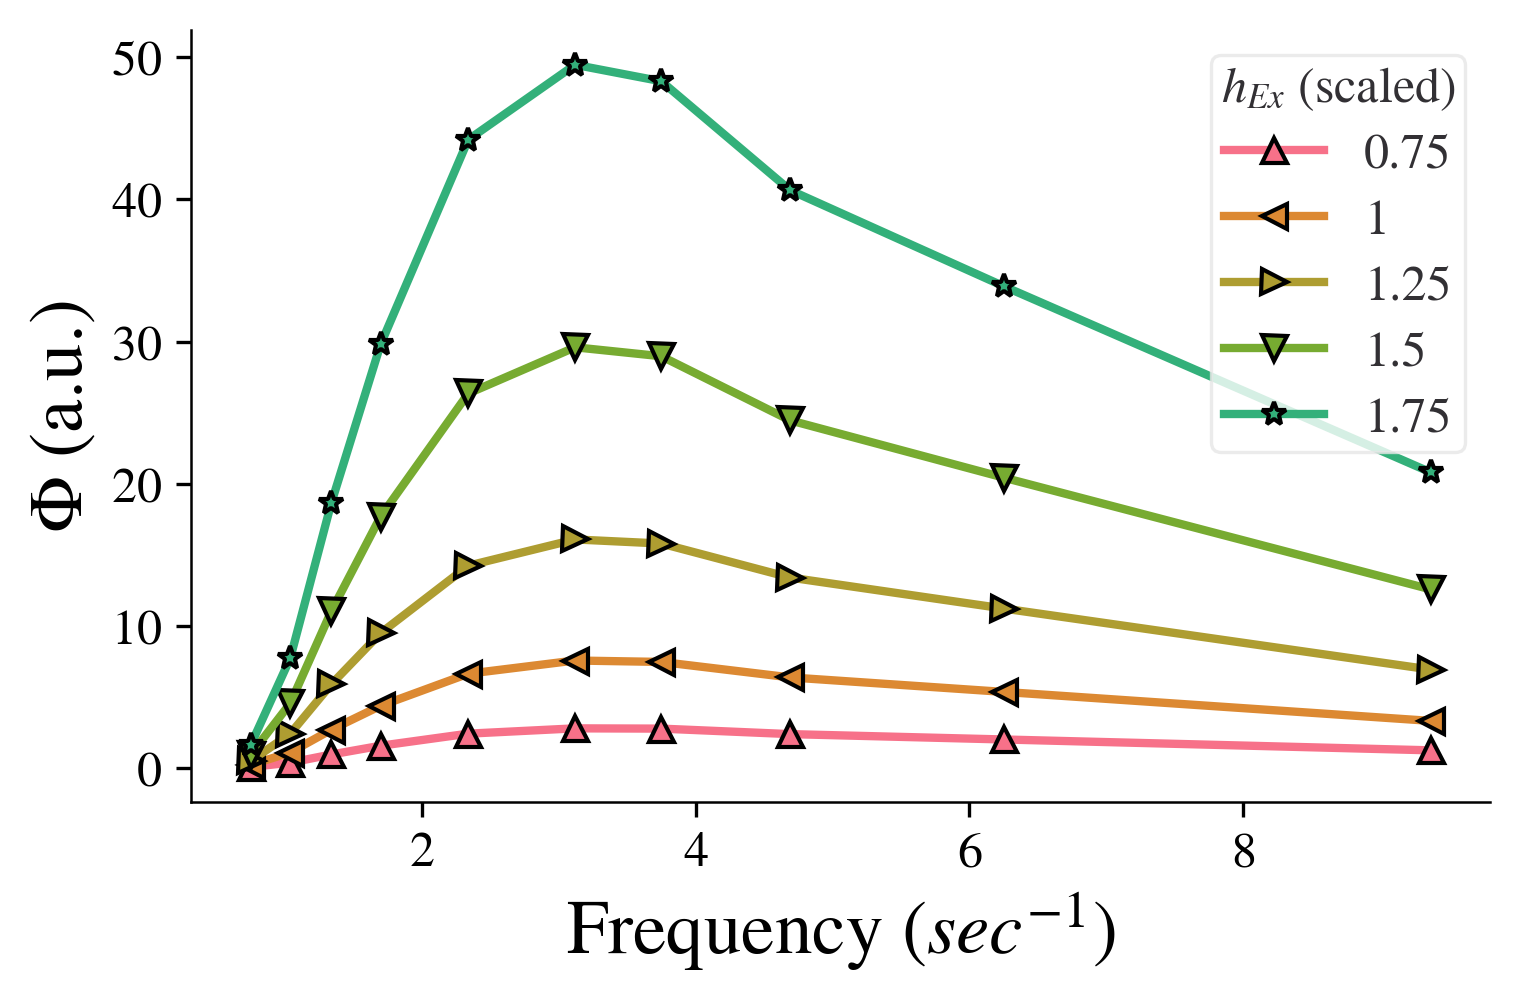

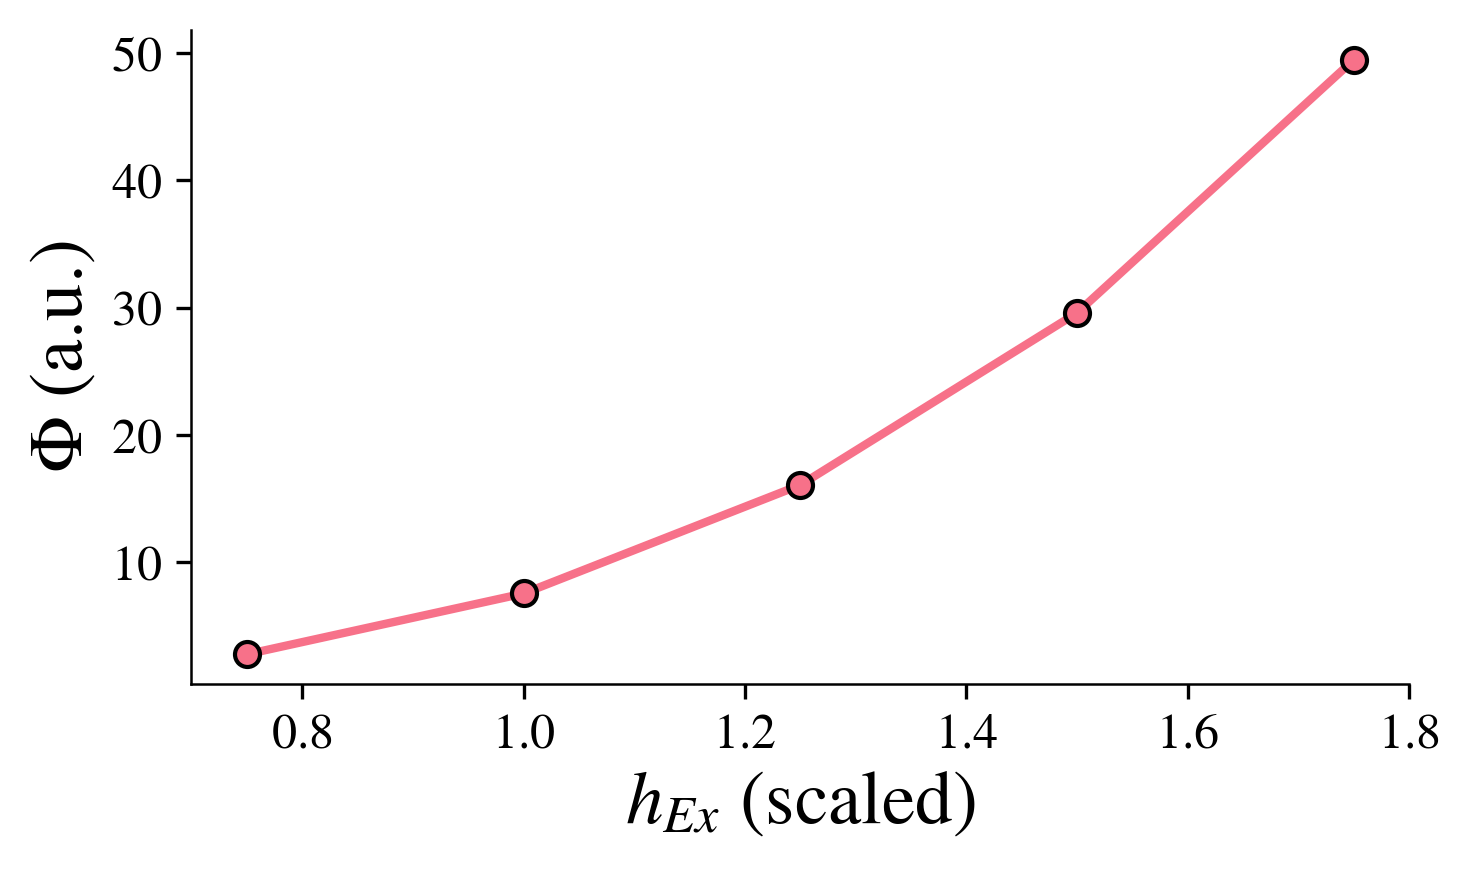

In [15]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',prop_cycle= colors)



plt.figure(figsize=(s1, s2))
exc_overlap_list = np.array(exc_amp_overlap_list)
for i in range(len(exc_amp_overlap_list)):
    plt.plot(frequency_list,np.squeeze(exc_amp_overlap_list[i]),marker=marker_list[i],label=str(this_amp_list[i]))

plt.xlabel(r'Frequency $(sec^{-1})$')
plt.ylabel("$\Phi$ (a.u.)")
plt.legend(title=r'$h_{Ex}$ (scaled)', loc='upper right',fontsize=12, title_fontsize=12), #bbox_to_anchor=(1, 0.45))

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_exc_amp_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'am_exc_amp_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


plt.figure(figsize=(5, 3))
max_overlap_list =[]
this_amp_list =[0.75,1,1.25,1.5,1.75]
for i in range(len(exc_overlap_list)):
    max_overlap_list.append(np.max((exc_overlap_list[i])))
plt.plot(this_amp_list, np.array(max_overlap_list),marker='o')
plt.xlabel(r'$h_{Ex}$ (scaled)')
plt.ylabel("$\Phi$ (a.u.)")

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'am_exc_amp_hi_plot.'+'png'),dpi=300)

with open(os.path.join(fig_save_path , 'am_exc_amp_hi_plot.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)










In [16]:
A = 1
B = 115
C=20
this_amp_exc= 2 /B #* 0.1 # h=0.46
this_amp_inh= 1 /C #* 5.75*0.1 # h=0.23

t_scale = 0.75
dt = 0.1 
#######
unit_2_scale=1
LGN_RF_scale =1.5
V1_RF_scale = LGN_RF_scale*2

dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale/1.5),dp*10*int(LGN_RF_scale/1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale/1.5)*unit_2_scale,dp*10*int(V1_RF_scale/1.5)*unit_2_scale+dp,dp) 

timestep = int(np.round(400 * t_scale ))

T = timestep * dt

boundary_size = 10 
pixel_size = 450

width_size = 20
peak = 1
trough = 0
pixel_ratio_scale= 8
time_st1 = 20


pixel_mid = int(np.round(pixel_size/2))+boundary_size

stimulus1_pos = int(np.round(pixel_size/pixel_ratio_scale))+boundary_size
pixel_st1 = stimulus1_pos - width_size
pixel_ed1 = stimulus1_pos + width_size

stimulus2_pos = pixel_ed1 + 2*pixel_ratio_scale*width_size
pixel_st2 = stimulus2_pos - width_size
pixel_ed2 = stimulus2_pos + width_size


this_alpha_list = np.array([0.003,0.002,0.001,0])*a_scale


frequency_list = [0.75, 1.04, 1.34, 1.7, 2.34, 3.12, 3.75, 4.69, 6.25, 9.37]

pal = sns.color_palette("crest", len(frequency_list)+1)
color_list = pal.as_hex()


inh_overlap_list =[]


this_amp_list =[0.25,0.5,0.75,1,1.25,1.5]#,1.75,2]


alpha_response_list = []
this_alpha=0.003*10

exc_and_alpha_overlap_list = []

for v1_exc_scale in this_amp_list:


    v1_sigma_Ex_scale = 1 * v1_exc_scale 
    v1_sigma_inh_scale =1 
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale


    alpha_response_list = []

    for this_alpha in tqdm(this_alpha_list):
        overlap = []

        for i in range(len(frequency_list)): 

            stimulus_duration= int(1/frequency_list[i]/4*300* t_scale)

            I = np.zeros((timestep, pixel_size+ 2*boundary_size ))

            I.fill(trough)

            time_ed1 = time_st1 + stimulus_duration


            time_st2 = time_ed1 + stimulus_duration
            time_ed2 = time_st2 + stimulus_duration

            I[time_st1:time_ed1, pixel_st1:pixel_ed1] = peak
            I[time_st2:time_ed2, pixel_st2:pixel_ed2] = peak


            X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc)

            this_X_vec = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
            this_X_vec_V1 = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
            this_X_vec_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
            this_X_vec_V1_2nd = net.get_bold_X_vec(dt, timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)


            a= this_X_vec_V1_2nd[time_ed1,pixel_ed1-20:pixel_ed1]
            b = this_X_vec_V1_2nd[time_ed2,pixel_ed2-20:pixel_ed2]

            response1 = this_X_vec_V1_2nd[:,pixel_ed1-20+np.argmax(a)]
            response2 = this_X_vec_V1_2nd[:,pixel_ed2-20+np.argmax(b)]
            
            overlap.append(net.get_2response_pdf_v(response1,response2))

        exc_and_alpha_overlap_list.append(overlap)









0
1
2
3
4
5


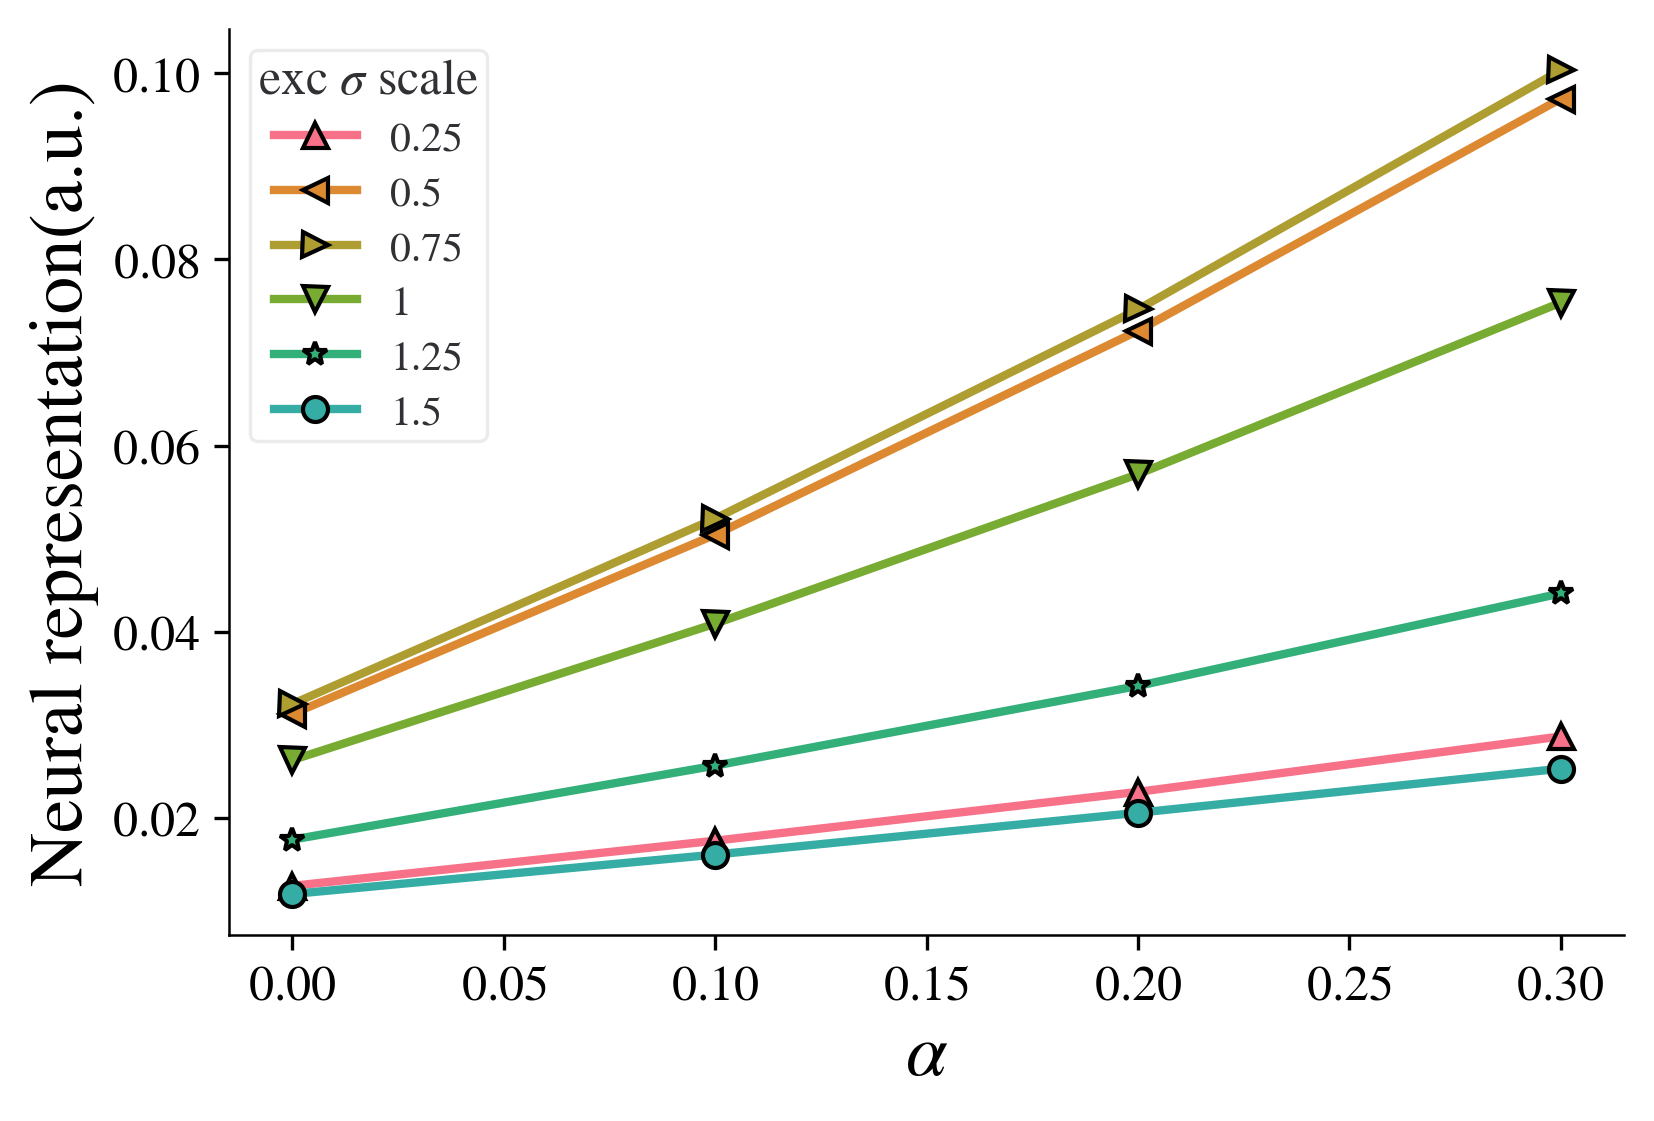

In [17]:
this_amp_list =[0.25,0.5,0.75,1,1.25,1.5]#,1.75,2]
pal=sns.color_palette("husl", 10)


len_j = len(this_alpha_list)

r_2d_wo_f = [] 
for i in range(len(this_amp_list)): 
    print(i)
    this_i_list = []
    for j in range(len(this_alpha_list)):
        this_i_list.append(np.max(np.array(exc_and_alpha_overlap_list)[i*len_j+j,:]))
    r_2d_wo_f.append(this_i_list)
    
for i in range(len(r_2d_wo_f)):  

    plt.plot(this_alpha_list,np.array(r_2d_wo_f)[i,:]/y_scale,label=str(this_amp_list[i]),marker=marker_list[i])
  
    
plt.xlabel(r'$\alpha$')
plt.ylabel('Neural representation(a.u.)')
plt.legend(title=r"exc $\sigma$ scale", loc='upper left')#, bbox_to_anchor=(1, 0.5))

with open(os.path.join(fig_save_path , 'am_al_exc_hi.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)